In [1]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset,DataLoader

import os

import umap
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.decomposition import PCA

from src.models import VAE
from src.training import Trainer

import pandas as pd
import seaborn as sns

from src.visualization import *

import pickle

from src.utils import cell_type_node

import plotly.graph_objects as go
import re
import string

In [2]:
data_path = '/stor/huakui/research/VB/ghx/joint-vae/datasets/PBMC_8ct'
train = torch.load(os.path.join(data_path,'train_dataset.pt'))
val = torch.load(os.path.join(data_path,'val_dataset.pt'))
group_indexes = np.load(os.path.join(data_path,'disc_labels_mapping.npy'), allow_pickle = True).item()
group_indexes_reverse = dict()
for group in group_indexes:
    group_indexes_reverse[group] = {value:key for key,value in group_indexes[group].items()}
ln_file = open(os.path.join(data_path, 'label_names.txt'),'r')
label_names = ln_file.read().splitlines()
ln_file.close()

In [3]:
tree_file = open(os.path.join(data_path,'cluster_tree.obj'),'rb')
tree = pickle.load(tree_file)
for depth in range(tree.depth()+1):
    layer_node = [node for node in tree.all_nodes() if tree.depth(node=node)==depth]
    for node in layer_node:
        node.data.cell_type_cluster_id = group_indexes['level'+str(depth)][node.data.cell_type_name]

In [4]:
depth = tree.depth()
tree_layer_to_disc_mapping = {idx:2+depth-idx for idx in range(depth+1)}

In [5]:
label_name_cont = [idx for idx,name in enumerate(label_names) if name not in group_indexes]
label_name_disc = [idx for idx,name in enumerate(label_names) if name in group_indexes]
# cont: 2 diffused latent, 2 kl latent, each label has a latent to supervise
# disc: 1 clustering latent, 1 kl latent, each label has a latent to supervise
diffuse_cont_dims = [0,1]
KL_cont_dims = [2,3]
unsupervised_cont_num = len(diffuse_cont_dims + KL_cont_dims)
cluster_disc_dims = [0]
KL_disc_dims = [1]
unsupervised_disc_num = len(cluster_disc_dims + KL_disc_dims)
n_cluster = 5
latent_spec = {'cont': len(label_name_cont) + unsupervised_cont_num, 
               'disc': unsupervised_disc_num*[n_cluster] + [len(i) for i in group_indexes.values()]}


cont_supervise_dict = {idx+len(diffuse_cont_dims)+len(KL_cont_dims):cont_dim for idx,cont_dim in enumerate(label_name_cont)}
disc_supervise_dict = {idx+len(cluster_disc_dims)+len(KL_disc_dims):disc_dim for idx,disc_dim in enumerate(label_name_disc)}
latent_name_cont = [str(i)+'_Diffuse' for i in diffuse_cont_dims] + \
                   [str(i)+'_KL_Cont' for i in KL_cont_dims] +\
                   [str(i)+'_'+label_names[cont_supervise_dict[i]] for i in cont_supervise_dict]
latent_name_disc = [str(i)+'_Cluster' for i in cluster_disc_dims] + \
                   [str(i)+'_KL_Disc' for i in KL_disc_dims] +\
                   [str(i)+'_'+label_names[disc_supervise_dict[i]] for i in disc_supervise_dict]

In [6]:
savePath = '/stor/huakui/research/VB/ghx/joint-vae/results/PBMC_8ct'
if not os.path.exists(savePath):
    os.makedirs(savePath)
save_figs = False

In [7]:
cluster_disc_dims = [0,2,3,4,5,6]

In [8]:
#latent_spec = {'cont': 5,'disc': [4,4,5,6]}
model = VAE(latent_spec=latent_spec, 
            data_size = (len(train[0][0]),1), 
            use_cuda = torch.cuda.is_available())
# Build optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-4)
# Define the capacities
# Continuous channels
cont_capacity = [0.0, 5.0, 25000, 30.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0
# Discrete channels
disc_capacity = [0.0, 5.0, 25000, 30.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0
# Build a trainer
trainer = Trainer(model, optimizer,
                  cont_capacity=cont_capacity,disc_capacity=disc_capacity,
                  clustering_lambda = 0.01, cluster_disc_dims = cluster_disc_dims,
                  diffusion_lambda=1, diffuse_cont_dims = diffuse_cont_dims, 
                  sigma = 5, random_walk_step = 1,
                  discrete_supervised_lambda = 100, disc_supervise_dict = {2:0},
                  continuous_supervised_lambda = 0, cont_supervise_dict = cont_supervise_dict,
                  cont_loss_type = 'mse', scaling_loss = True, 
                  hierarchy_lambda = 100000, cluster_tree = tree, 
                  tree_layer_to_disc_mapping = tree_layer_to_disc_mapping,
                  print_loss_every=100, record_loss_every=5,
                  use_cuda = torch.cuda.is_available(), verbose = False)
train_loader = DataLoader(train, batch_size=128,shuffle=True)
# Train model 
trainer.train(train_loader, epochs = 400)

Epoch 400: 100%|██████████| 400/400 [03:39<00:00,  1.82it/s, Epoch_average_loss=8486.33]


In [97]:
for data in DataLoader(val,batch_size=len(val),shuffle=False):
    break 
x = data[0].view(data[0].size(0),-1).cuda()
with torch.no_grad():
    latent_sample,latent_dist = model(x)
z_hat = torch.argmax(latent_dist['disc'][0],dim = 1)

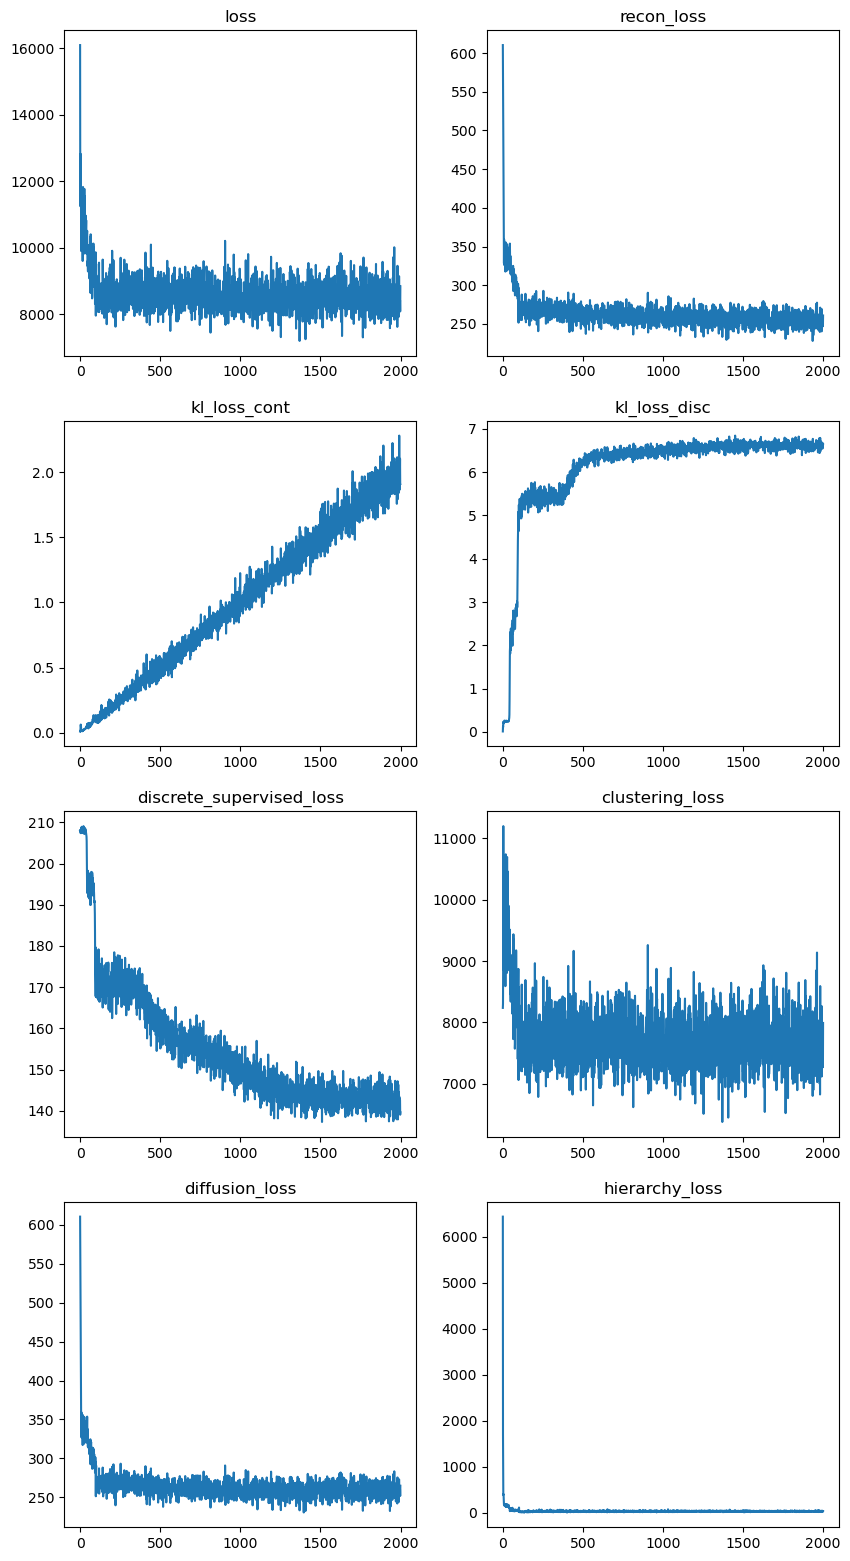

In [10]:
fig = draw_loss_curves(trainer.losses)
if save_figs:
    fig.savefig(os.path.join(savePath, 'img', 'fig1_lossCurves.png'))
fig.show()

In [98]:
# discrete labels
# each disc label dim is with its supervising latent
labels_disc = pd.DataFrame()
for latent in disc_supervise_dict:
    label_name = label_names[disc_supervise_dict[latent]]
    group_index = group_indexes_reverse[label_name]
    label_pos = [idx for idx,name in enumerate(label_names) if name==label_name][0]
    label = data[1][:,label_pos].int()
    labels_disc[label_name + ' (Label)'] = [group_index[int(i)] for i in label]
    label_hat = torch.argmax(latent_dist['disc'][latent].detach().cpu(),dim = 1)
    labels_disc[label_name + ' (Infer)'] = np.array(label_hat)
# disc latent that under clustering constrain (and also KL)
# cluster_disc_dims = [0]
for idx, latent in enumerate(cluster_disc_dims):
    label_hat = torch.argmax(latent_dist['disc'][latent].detach().cpu(),dim = 1)
    labels_disc['Cluster_Dim_'+str(idx)] = np.array(label_hat)
# disc latent that only under KL constrain
# KL_disc_dims = [i for i in range(len(latent_spec['disc'])) if i not in cluster_disc_dims and i not in disc_supervise_dict]
for idx, latent in enumerate(KL_disc_dims):
    label_hat = torch.argmax(latent_dist['disc'][latent].detach().cpu(),dim = 1)
    labels_disc['KL_Dim_'+str(idx)] = np.array(label_hat)

In [99]:
# continuous labels
# each cont label dim is with its supervising latent
labels_cont = pd.DataFrame()
for latent in cont_supervise_dict:
    label_name = label_names[cont_supervise_dict[latent]]
    label_pos = [idx for idx,name in enumerate(label_names) if name==label_name][0]
    labels_cont[label_name+' (Label)'] = np.array(data[1][:,label_pos])
    label_hat = latent_dist['cont'][0][:,latent].detach().cpu()
    labels_cont[label_name + ' (Infer)'] = np.array(label_hat)
# cont latent that under diffusion constrain
# diffusion_cont_dims = [0,1]
for idx, latent in enumerate(diffuse_cont_dims):
    label_hat = latent_dist['cont'][0][:,latent].detach().cpu()
    labels_cont['Diffuse_Dim_'+str(idx)] = np.array(label_hat)
# cont latent that only under KL constrain
# KL_cont_dims = [i for i in range(latent_spec['cont']) if i not in diffuse_cont_dims and i not in cont_supervise_dict]
for idx, latent in enumerate(KL_cont_dims):
    label_hat = latent_dist['cont'][0][:,latent].detach().cpu()
    labels_cont['KL_Dim_'+str(idx)] = np.array(label_hat)

In [100]:
pc_file = os.path.join(data_path, 'pca.npy')
if False:# os.path.isfile(pc_file):
    pcs = np.load(os.path.join(data_path, 'pca.npy'))
else:
    pca = PCA(n_components=50)
    pca.fit(data[0].detach().cpu())
    pcs = pca.transform(data[0].detach().cpu())
    np.save(file = pc_file, 
             arr = pcs)

In [101]:
umap_file = os.path.join(data_path, 'umap.npy')
if False:# os.path.isfile(umap_file):
    u = np.load(umap_file)
else:
    u  = umap.UMAP().fit_transform(pcs)
    np.save(file = umap_file, 
            arr = u)

In [15]:
tree.show()

Immune Cells
├── Lymphocyte
│   ├── B cell
│   │   └── B cell
│   │       └── B cell
│   ├── NK cells
│   │   └── NK cells
│   │       └── NK cells
│   └── T cell
│       ├── mature T cell
│       │   ├── T helper
│       │   ├── Treg
│       │   └── memory T cell
│       └── naive T cell
│           ├── naive T cell
│           └── naive cytotoxic
└── Myeloid cell
    └── Monocytes
        └── Monocytes
            └── Monocytes



In [16]:
tree.show(data_property='cell_type_cluster_id')

0
├── 0
│   ├── 3
│   │   └── 4
│   │       └── 3
│   ├── 2
│   │   └── 3
│   │       └── 1
│   └── 0
│       ├── 0
│       │   ├── 6
│       │   ├── 5
│       │   └── 2
│       └── 1
│           ├── 4
│           └── 7
└── 1
    └── 1
        └── 2
            └── 0



In [102]:
ARI_dict = {}
for ar in ['level1','level2','level3','level4']:
    tempLabel = labels_disc[ar+' (Label)']
    tempInfer = labels_disc[ar+' (Infer)']
    tempARI = sklearn.metrics.adjusted_rand_score(tempLabel,tempInfer)
    ARI_dict[ar] = tempARI
ARI_dict

{'level1': 0.9872985946188545,
 'level2': 0.8926691528388284,
 'level3': 0.6774876228024993,
 'level4': 0.6607167488930554}

In [32]:
for depth in range(tree.depth(),0,-1):
    layer_node = [node for node in tree.all_nodes() if tree.depth(node=node)==depth]
    layer_ct = [node.data.cell_type_name for node in layer_node]
    parents_ct = [tree.parent(nid = node.identifier).data.cell_type_name for node in layer_node]
    pdata['level'+str(depth-1)] = pdata['level'+str(depth)].replace(layer_ct, parents_ct)

['Immune Cells',
 'Lymphocyte',
 'Myeloid cell',
 'B cell',
 'T cell',
 'Monocytes',
 'NK cells',
 'naive T cell',
 'mature T cell',
 'naive.cytotoxic',
 'naive.t',
 'memory.t',
 'regulatory.t',
 'cd4.t.helper',
 'B cell',
 'b.cells',
 'Monocytes',
 'cd14.monocytes',
 'NK cells',
 'cd56.nk']

In [103]:
cooccur = {}
for layer in [1,2,3,4]:
    curr_layer_label = labels_disc['level'+str(layer)+' (Infer)']
    last_layer_label = labels_disc['level'+str(layer-1)+' (Infer)']
    
    curr_layer_ct = set(curr_layer_label)
    last_layer_ct = set(last_layer_label)
    
    for i in last_layer_ct:
        cooccur[('layer '+str(layer-1),i)] = {}
        for j in curr_layer_ct:
            cooccur[('layer '+str(layer-1),i)][('layer '+str(layer),j)] = sum([_l and _i for _l,_i in zip(last_layer_label == i,
                                                             curr_layer_label == j)])

In [94]:
def toRgb(tmp):
    tmp = tmp.strip('#')
    opt = re.findall(r'(.{2})',tmp)
    strs = ""
    for i in range (0, len(opt)):
        strs += str(int(opt[i], 16)) + ","
    return('rgba('+strs+'0.4)')

In [104]:
tails = []
for l in [list(cooccur[key].keys()) for key in cooccur.keys()]:
    tails = tails+l

nodes = list(set(cooccur.keys()) | set(tails))
nodes.sort()
    
data = {'node':{'label': nodes, 
                'color': ['#F8766D','#EA8331','#D89000','#C09B00','#A3A500',
                          '#7CAE00','#39B600','#00BB4E','#00BF7D','#00C1A3','#00BFC4',
                          '#00BAE0','#00B0F6','#35A2FF','#9590FF','#C77CFF','#E76BF3','#FA62DB','#FF62BC','#FF6A98']}, 
        'link':{i:[] for i in ['source','target','value','label','color']}}

colors = {l:c for l,c in zip(data['node']['label'],
                              data['node']['color'])}

for idx,i in enumerate(data['node']['label']):
    if i not in cooccur:
        continue
    for jdx,j in enumerate(data['node']['label']):
        if j not in cooccur[i]:
            continue
        data['link']['source'].append(idx)
        data['link']['target'].append(jdx)
        data['link']['value'].append(cooccur[i][j])
        data['link']['label'].append('')
        data['link']['color'].append(toRgb(colors[i]))

In [109]:
fig = go.Figure(data=[go.Sankey(
    valueformat = ".0f",
    # Define nodes
    node = dict(
      pad = 15,
      thickness = 15,
      line = dict(color = "black", width = 0.5),
      label =  data['node']['label'],
      color =  data['node']['color']
    ),
    # Add links
    link = dict(
      source =  data['link']['source'],
      target =  data['link']['target'],
      value =  data['link']['value'],
      label =  data['link']['label'],
      color =  data['link']['color']
))])

fig.update_layout(title_text="cell type to latent discrete dimension",
                  font_size=10)
fig.show()

In [23]:
layer_nodes = []
for depth in range(0,tree.depth()+1):
    layer_nodes.append([node for node in tree.all_nodes() if tree.depth(node=node)==depth])

{'b.cells',
 'cd14.monocytes',
 'cd4.t.helper',
 'cd56.nk',
 'memory.t',
 'naive.cytotoxic',
 'naive.t',
 'regulatory.t'}

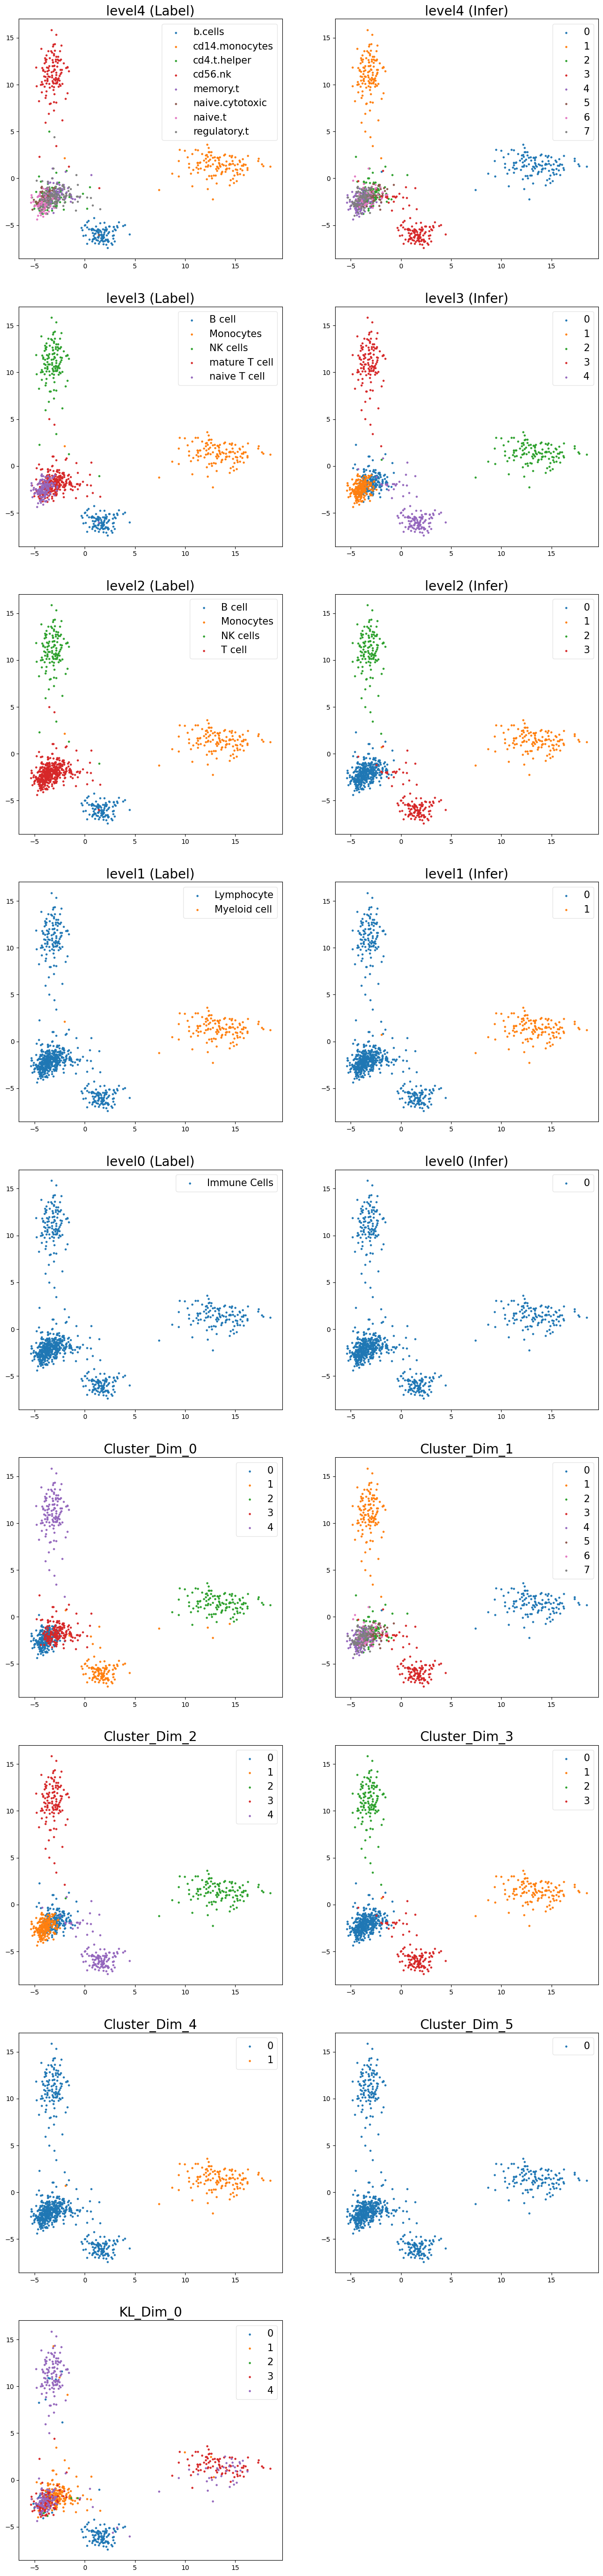

In [108]:
fig = draw_scatter_with_discrete_labels(pcs, labels_disc)
fig.show()

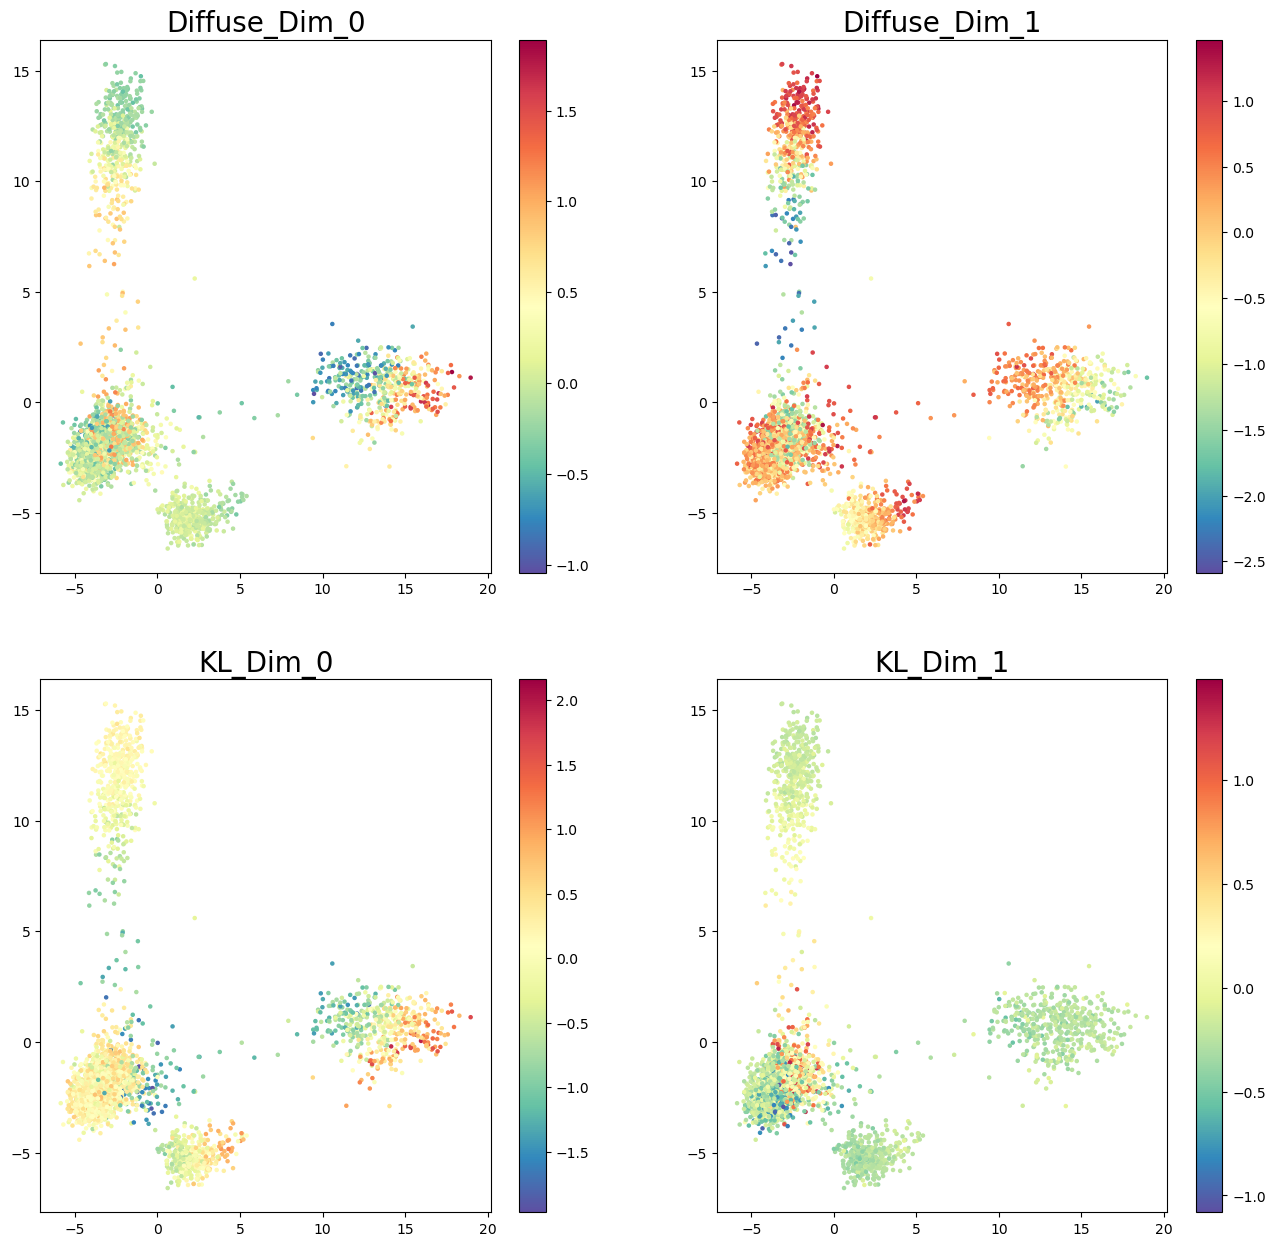

In [19]:
fig = draw_scatter_with_continuous_labels(pcs, labels_cont)
fig.show()

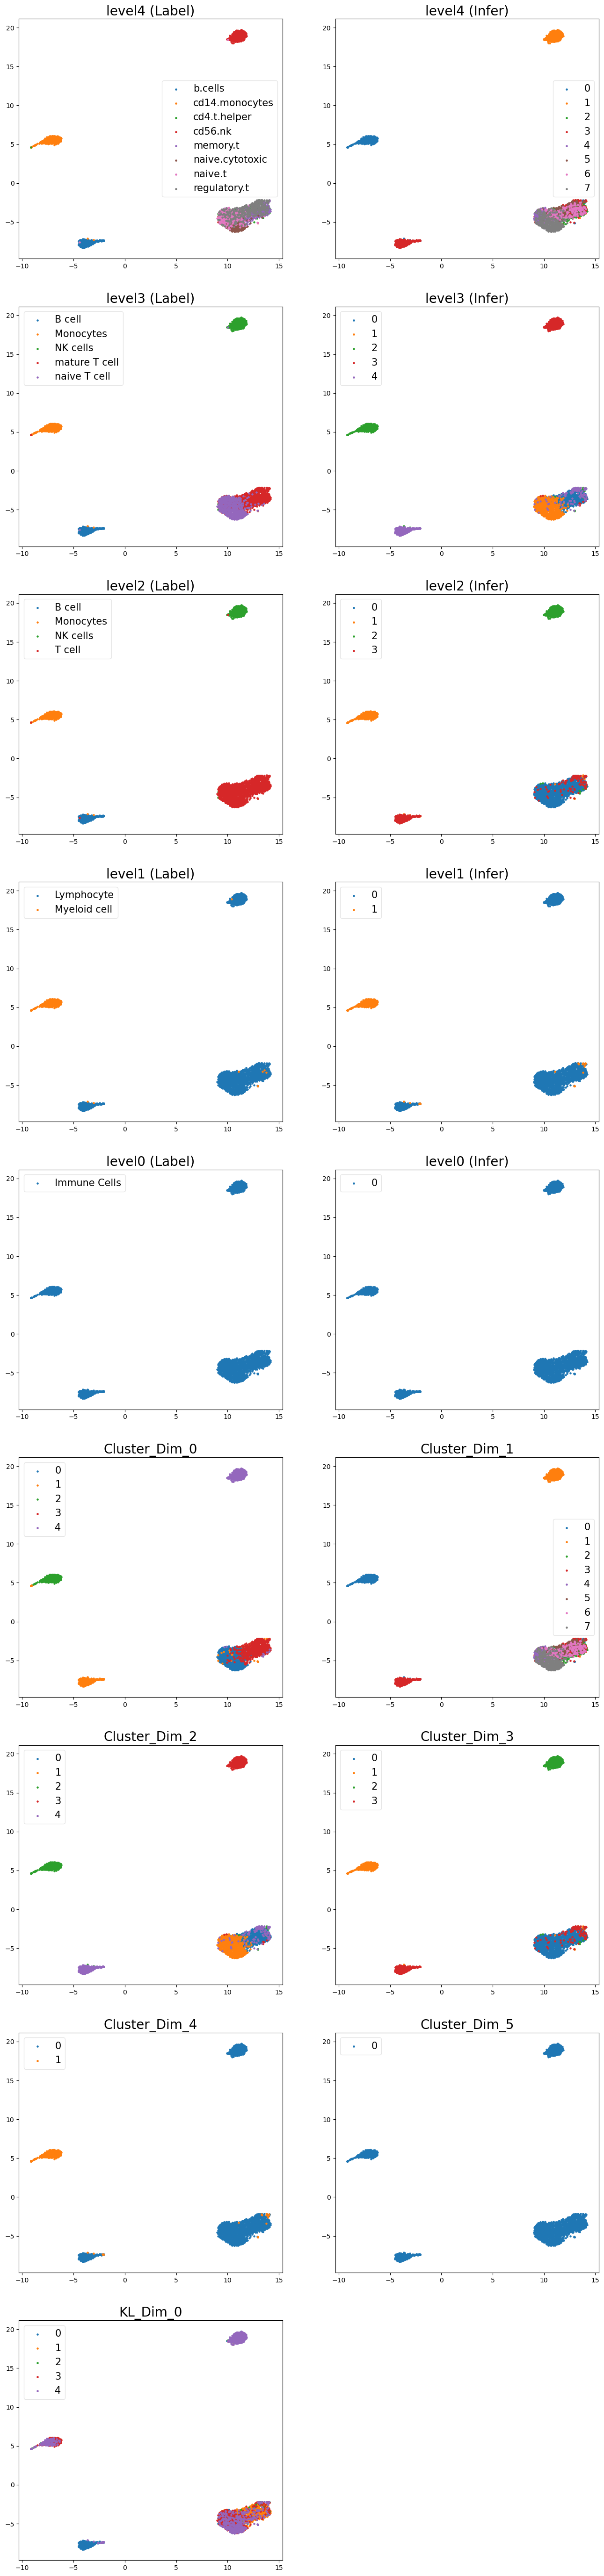

In [20]:
fig = draw_scatter_with_discrete_labels(u, labels_disc)
fig.show()

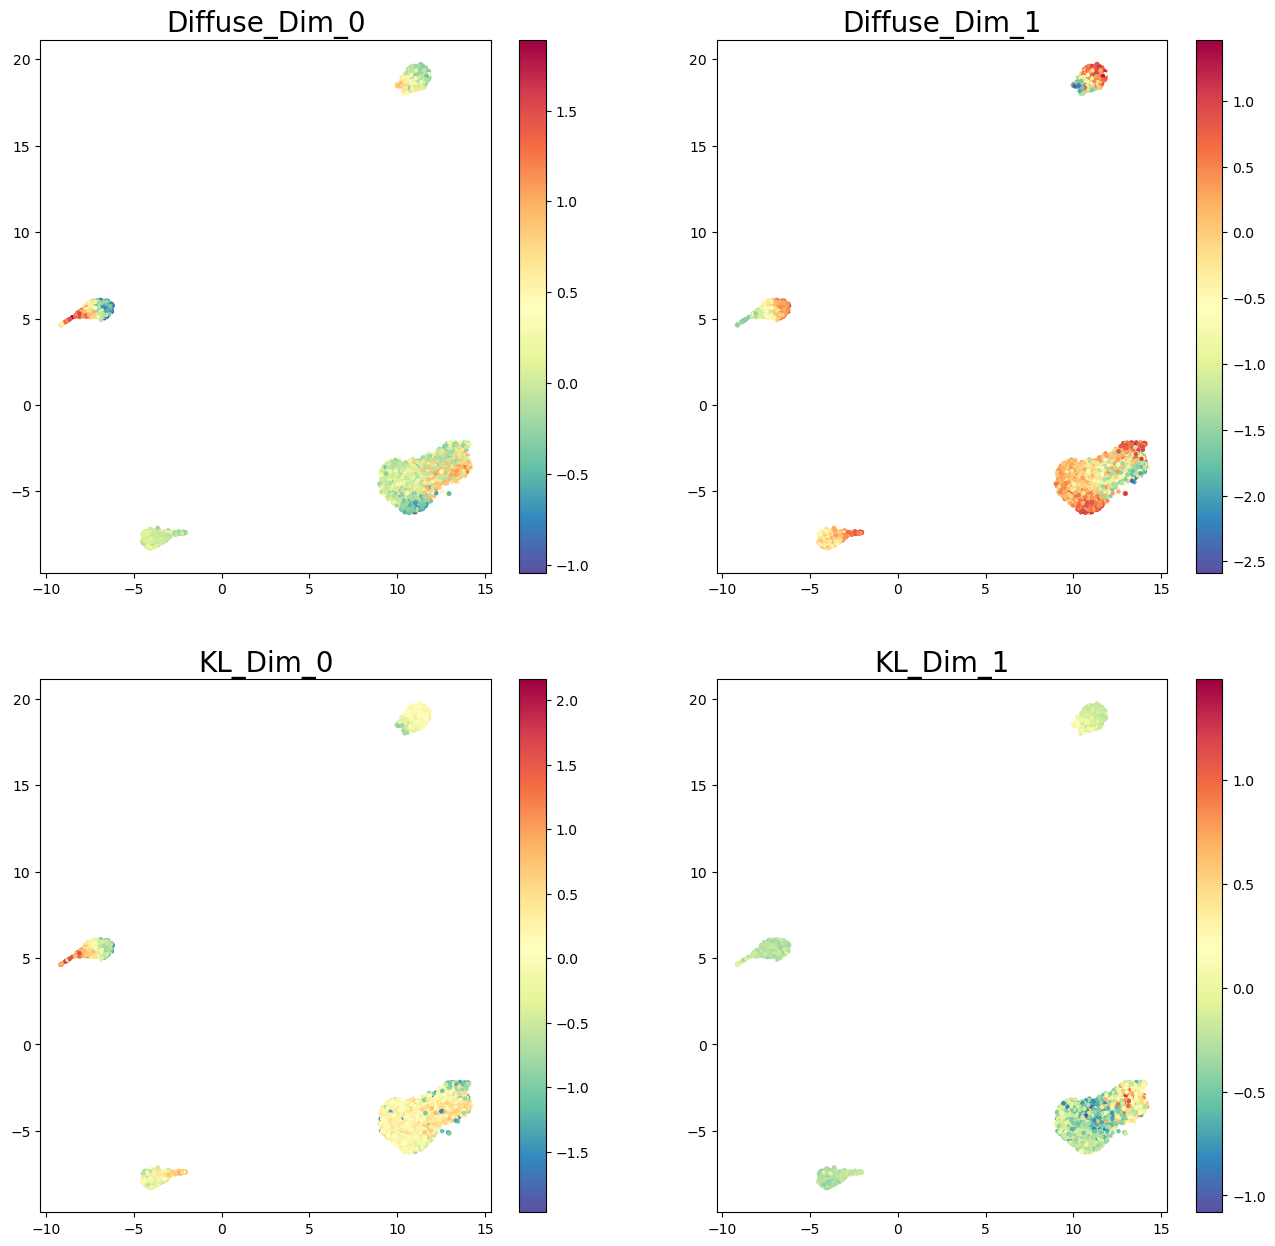

In [21]:
fig = draw_scatter_with_continuous_labels(u, labels_cont)
fig.show()

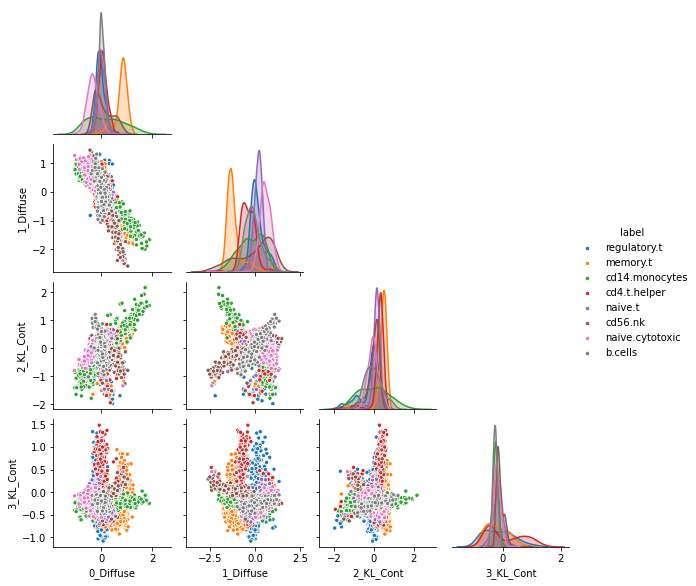

In [22]:
max_draw_cont = 4
label_name = 'level4'
label_pos = [idx for idx,name in enumerate(label_names) if name==label_name][0]
group_index = group_indexes_reverse[label_name]
embeddings = np.array(latent_dist['cont'][0].cpu())
embeddings = embeddings[:,0:min(max_draw_cont, len(embeddings))]
embeddings = pd.DataFrame(embeddings)
embeddings.columns = latent_name_cont
embeddings['label'] = [group_index[int(i)] for i in data[1][:,label_pos].int()]

fig = sns.pairplot(embeddings,hue="label", plot_kws={'size':1}, height = 2, aspect = 1, corner=True)
plt.show()